In [1]:
from Data_Enrichment import get_features

RAW_DIR = "data/raw"
df_feats, feature_cols = get_features(RAW_DIR)
df_feats = df_feats[(df_feats['season_end_year'] != 2025) & (df_feats['season_end_year'] != 2026)]


/workspaces/Machine-learning/Data_Enrichment.py:232: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ballon_dor_winner"] = df["ballon_dor_winner"].fillna(False).astype(bool)


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
X_numeric = df_feats.select_dtypes(include=['int64', 'float64'])


In [4]:
from sklearn.ensemble import RandomForestRegressor
np.random.seed(30) #we fix the seed so we can reproduce the data any time

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_numeric, df_feats["ballon_dor_winner"])

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
ncol=X_numeric.shape[1]-1
data_df=X_numeric.iloc[:,0:ncol]

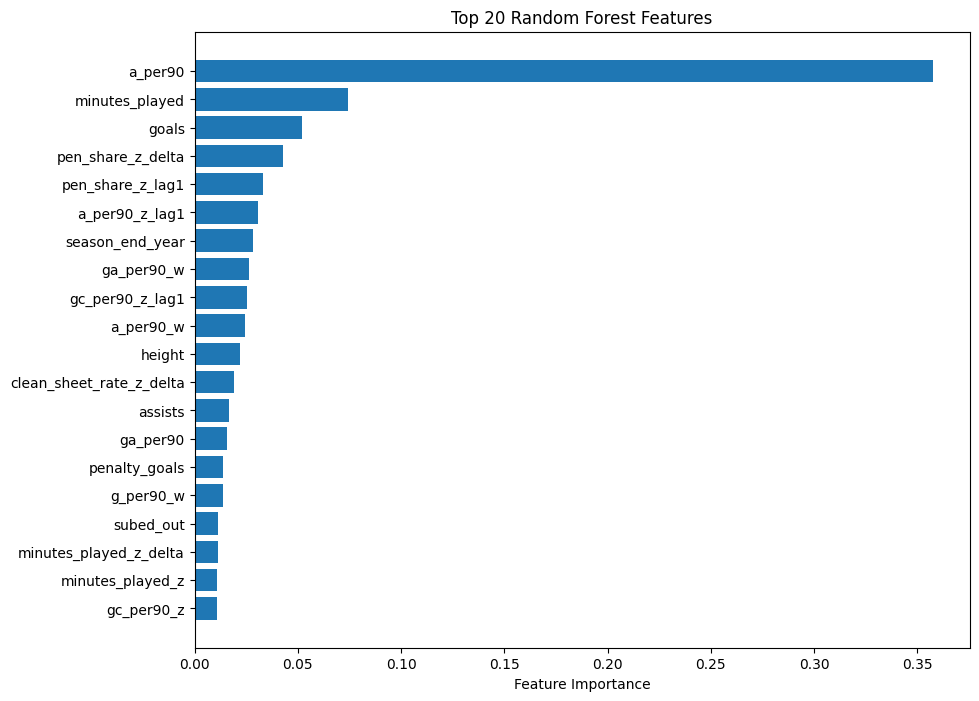

In [7]:
import matplotlib.pyplot as plt

feature_names = X_numeric.columns  # columnas usadas en entrenamiento
importances = rf.feature_importances_

# Top 20 features más importantes
top_idx = importances.argsort()[::-1][:20]

plt.figure(figsize=(10, 8))
plt.barh(feature_names[top_idx], importances[top_idx])
plt.xlabel("Feature Importance")
plt.title("Top 20 Random Forest Features")
plt.gca().invert_yaxis()  # más importante arriba
plt.show()
